In [6]:
%run talktools

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma


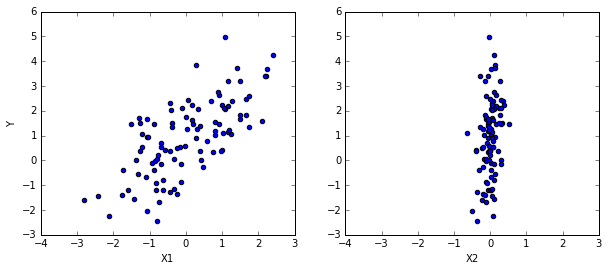

In [2]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

In [3]:
from pymc3 import Model, Normal, HalfNormal
basic_model = Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma = HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)


Applied log-transform to sigma and added transformed sigma_log_ to model.


In [4]:
from pymc3 import find_MAP

map_estimate = find_MAP(model=basic_model)

print(map_estimate)

{'alpha': array(0.9065985664354854), 'beta': array([ 0.948486  ,  2.60705513]), 'sigma_log_': array(-0.03278146854842086)}


In [5]:
from scipy import optimize

map_estimate = find_MAP(model=basic_model, fmin=optimize.fmin_powell)

print(map_estimate)

{'alpha': array(0.9090521898976851), 'beta': array([ 0.95140146,  2.61437458]), 'sigma_log_': array(-0.030009775202848074)}


In [6]:

from pymc3 import NUTS, sample

with basic_model:

    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)

    # draw 2000 posterior samples
    trace = sample(2000, start=start)

Assigned NUTS to alpha
Assigned NUTS to beta
Assigned NUTS to sigma_log_
 [-----------------100%-----------------] 2000 of 2000 complete in 1.1 sec

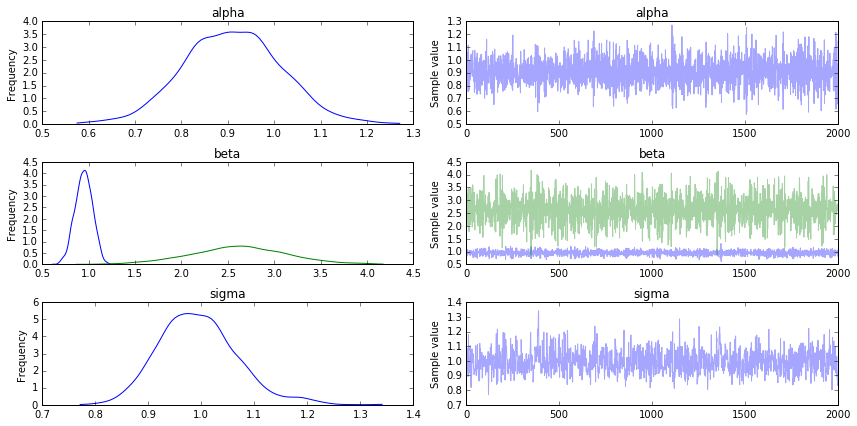

In [7]:
from pymc3 import traceplot
traceplot(trace);

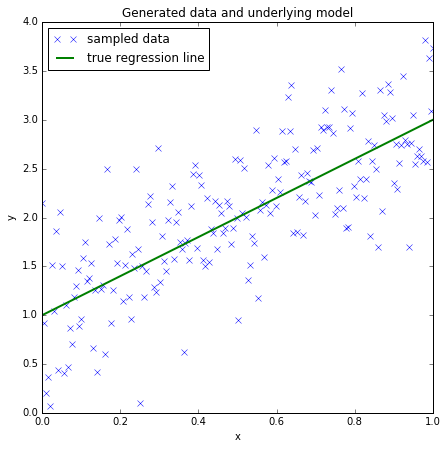

In [8]:
%matplotlib inline

from pymc3 import  *
import patsy
import numpy as np
import matplotlib.pyplot as plt
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [9]:
with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy('sigma', beta=10, testval=1.)
    intercept = Normal('Intercept', 0, sd=20)
    x_coeff = Normal('x', 0, sd=20)

    # Define likelihood
    likelihood = Normal('y', mu=intercept + x_coeff * x,
                        sd=sigma, observed=y)

    # Inference!
    start = find_MAP() # Find starting value by optimization
    step = NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = sample(2000, step, start=start, progressbar=True) # draw 2000 posterior samples using NUTS sampling

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '4880' (I am process '8012')


Applied log-transform to sigma and added transformed sigma_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.3 sec

In [11]:
with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    glm.glm('y ~ x', data)
    start = find_MAP()
    step = NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = sample(2000, step, progressbar=True) # draw 2000 posterior samples using NUTS sampling

Applied log-transform to sd and added transformed sd_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.9 sec

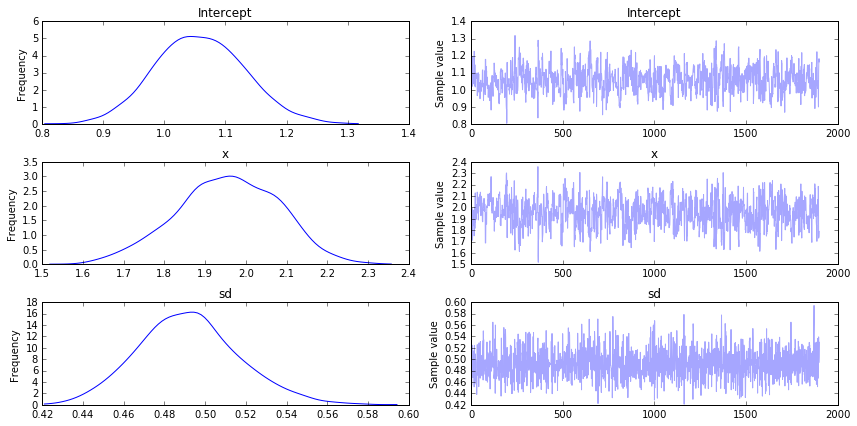

In [12]:
plt.figure(figsize=(7, 7))
traceplot(trace[100:])
plt.tight_layout();

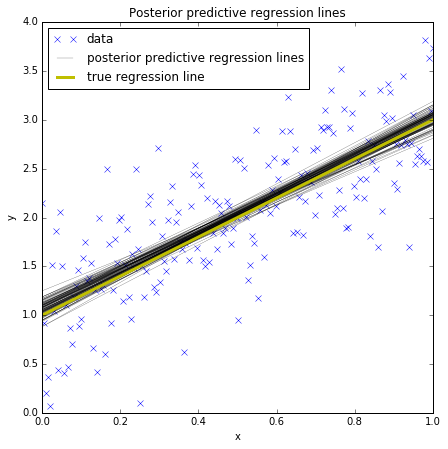

In [13]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
glm.plot_posterior_predictive(trace, samples=100,
                              label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');

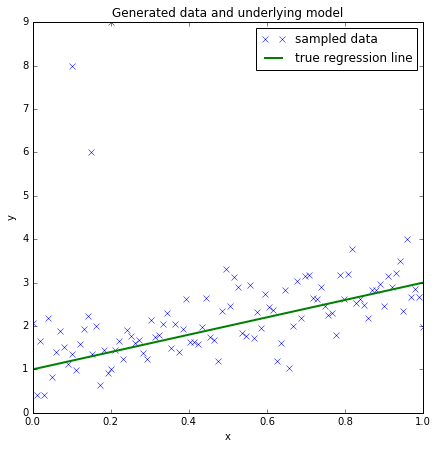

In [14]:
%matplotlib inline

import pymc3 as pm

import matplotlib.pyplot as plt
import numpy as np

import theano
size = 100
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

# Add outliers
x_out = np.append(x, [.1, .15, .2])
y_out = np.append(y, [8, 6, 9])

data = dict(x=x_out, y=y_out)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x_out, y_out, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [15]:
with pm.Model() as model:
    pm.glm.glm('y ~ x', data)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(2000, step, progressbar=True)

Applied log-transform to sd and added transformed sd_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.8 sec

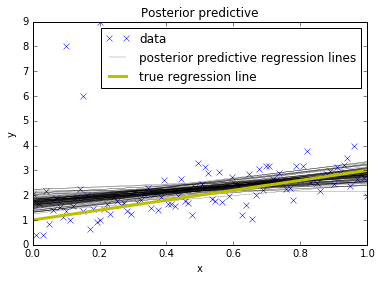

In [16]:
plt.subplot(111, xlabel='x', ylabel='y',
            title='Posterior predictive regression lines')
plt.plot(x_out, y_out, 'x', label='data')
pm.glm.plot_posterior_predictive(trace, samples=100,
                                 label='posterior predictive regression lines')
plt.plot(x, true_regression_line,
         label='true regression line', lw=3., c='y')

plt.legend(loc=0);

Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.9 sec

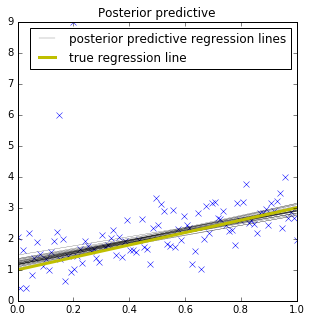

In [21]:
with pm.Model() as model_robust:
    family = pm.glm.families.StudentT()
    pm.glm.glm('y ~ x', data, family=family)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_robust = pm.sample(2000, step, progressbar=True)

plt.figure(figsize=(5, 5))
plt.plot(x_out, y_out, 'x')
pm.glm.plot_posterior_predictive(trace_robust,
                                 label='posterior predictive regression lines')
plt.plot(x, true_regression_line,
         label='true regression line', lw=3., c='y')
plt.legend();

In [18]:
normal_dist = pm.Normal.dist(mu=0, sd=1)
t_dist = pm.T.dist(mu=0, lam=1, nu=1)
x_eval = np.linspace(-8, 8, 300)
plt.plot(x_eval, theano.tensor.exp(normal_dist.logp(x_eval)).eval(), label='Normal', lw=2.)
plt.plot(x_eval, theano.tensor.exp(t_dist.logp(x_eval)).eval(), label='Student T', lw=2.)
plt.xlabel('x')
plt.ylabel('Probability density')
plt.legend();

AttributeError: 'module' object has no attribute 'T'